In [1]:
%matplotlib inline
from d2l import torch as d2l
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

In [2]:
from data_downloader import *

In [3]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [4]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [5]:
print(train_data.shape)

(1460, 81)


In [6]:
print(test_data.shape)

(1459, 80)


In [7]:
print(train_data.iloc[0:4, list(range(-3,4))])

  SaleType SaleCondition  SalePrice  Id  MSSubClass MSZoning  LotFrontage
0       WD        Normal     208500   1          60       RL         65.0
1       WD        Normal     181500   2          20       RL         80.0
2       WD        Normal     223500   3          60       RL         68.0
3       WD       Abnorml     140000   4          70       RL         60.0


We remove the ID feature as it doesn't add anything to prediction

In [8]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

Standardise the numeric features to zero mean and unit variance

In [9]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
# 'numeric_features' is now a set of column names

all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# After standardizing the data all means vanish, hence we can set missing
# values to 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

One-hot encode the discrete features, increasing the number of features

In [10]:
# `Dummy_na=True` considers "na" (missing value) as a valid feature value, and
# creates an indicator feature for it
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [11]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

We train a linear model with squared loss to start

In [12]:
loss = nn.MSELoss()
in_features = train_features.shape[1]  # The size of our input layer

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))  # A single layer
    return net

In [13]:
def log_rmse(net, features, labels):
    #     To further stabilise values when the log is taken, set values
    #     less than 1 to be equal to 1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
#     rmse = torch.sqrt(torch.mean(loss(torch.log(clipped_preds), torch.log(labels))))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    #TOASK shouldn't torch.mean() above be removed, because 'loss' is already MSE?
    return rmse.item()

In [14]:
def log_train(preds, labels):
    clipped_preds = torch.clamp(preds, 1, float('inf'))
    import ipdb; ipdb.set_trace()
#     rmse = torch.sqrt(torch.mean((torch.log(clipped_preds) - torch.log(labels)) ** 2))
    rmse = torch.mean((torch.log(clipped_preds) - torch.log(labels)) ** 2)
    return rmse

In [15]:
def log_train2(preds, labels):
    clipped_preds = torch.clamp(preds, 1, float('inf'))
    mse_log = loss(torch.log(clipped_preds), torch.log(labels))
    return mse_log

In [16]:
def loss_mse_manual(preds, labels):
    mse = torch.mean((preds - labels) ** 2)
    return mse

I ran it once using the MSE of the logs to train instead of the absolute values, and then realised this was a bad idea because the initial parameters of the neural networks often were such that the first set of predictions were below 1. The predictions were then clamped (see function above) to be 1 rendering the gradients useless.

In [17]:
def train(net, train_features, train_labels, test_features, test_labels, 
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    
    optimizer = torch.optim.Adam(net.parameters(),
                                lr = learning_rate,
                                weight_decay = weight_decay)
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
#             l = log_train(net(X), y)
#             l = log_rmse_train(net, X, y)
#             l = loss_mse_manual(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    
    return train_ls, test_ls

To implement K-fold cross validation, we define a function that slices out the i'th fold of the data as validation data and returns the rest as training data

In [18]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [23]:
def k_fold(k, X_train, y_train, num_epochs, 
          learning_rate, weight_decay, batch_size, net = None):
    """
    Trains the net k times using each fold of data as a validation set,
    displays the losses as we go, and returns the average train loss, valid loss,
    at the end.
    """
    if net is None:
        net = get_net()
    training_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, 
                                  weight_decay, batch_size)
        training_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls], 
                    xlabel='epoch', ylabel='rmse',
                    legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
             f'valid log rmse {float(valid_ls[-1]):f}')
    
    return training_l_sum / k, valid_l_sum / k

Begin with an untuned set of hyperparameters

fold 1, train log rmse 0.170470, valid log rmse 0.157210
fold 2, train log rmse 0.162314, valid log rmse 0.192056
fold 3, train log rmse 0.163900, valid log rmse 0.168465
fold 4, train log rmse 0.167978, valid log rmse 0.154638
fold 5, train log rmse 0.163306, valid log rmse 0.183027
5-fold validation: avg train log rmse: 0.165594, avg valid log rmse: 0.171079


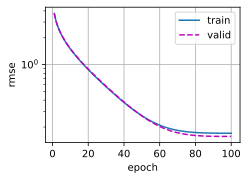

In [20]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, 
                         weight_decay, batch_size)

print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
     f'avg valid log rmse: {float(valid_l):f}')

Now let's try training our prediction

In [32]:
def train_and_pred(train_features, test_features, train_labels, test_data, 
                  num_epochs, lr, weight_decay, batch_size, fname='submission.csv', net=None):
    if net is None:
        net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, 
                       num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch', 
             ylabel='log rmse', yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    
    # Generate predictions from the test set
#     import ipdb; ipdb.set_trace()
    preds = net(test_features).detach().numpy()
    

    
    # Reformat the predictions for Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv(fname, index=False)
    

train log rmse 0.162632


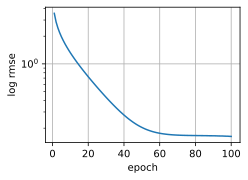

In [22]:
# This with the plain MSE loss function
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, 
              lr, weight_decay, batch_size)

Let's try a run with a deeper network

fold 1, train log rmse 0.130392, valid log rmse 0.146352
fold 2, train log rmse 0.120343, valid log rmse 0.154319
fold 3, train log rmse 0.121105, valid log rmse 0.149131
fold 4, train log rmse 0.125912, valid log rmse 0.148767
fold 5, train log rmse 0.113186, valid log rmse 0.149671
5-fold validation: avg train log rmse: 0.122188, avg valid log rmse: 0.149648


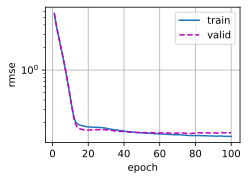

In [27]:
deeper_net = nn.Sequential(nn.Linear(in_features, 30),
                          nn.ReLU(),
                           nn.Linear(30, 1))

k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.05, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, 
                         weight_decay, batch_size, net=deeper_net)

print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
     f'avg valid log rmse: {float(valid_l):f}')

Even deeper!

fold 1, train log rmse 0.110425, valid log rmse 0.154295
fold 2, train log rmse 0.071214, valid log rmse 0.141309
fold 3, train log rmse 0.060347, valid log rmse 0.119590
fold 4, train log rmse 0.049742, valid log rmse 0.104173
fold 5, train log rmse 0.041135, valid log rmse 0.091412
5-fold validation: avg train log rmse: 0.066573, avg valid log rmse: 0.122156


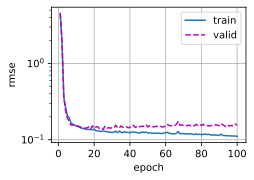

In [28]:
deeper_net = nn.Sequential(nn.Linear(in_features, 50),
                          nn.ReLU(),
                           nn.Linear(50, 10),
                           nn.ReLU(),
                           nn.Linear(10, 1))

k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.05, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, 
                         weight_decay, batch_size, net=deeper_net)

print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
     f'avg valid log rmse: {float(valid_l):f}')

I have a feeling we're overfitting here, so let's add some dropout

In [29]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight, std=0.01)

fold 1, train log rmse 0.040611, valid log rmse 0.079112
fold 2, train log rmse 0.029805, valid log rmse 0.079569
fold 3, train log rmse 0.024479, valid log rmse 0.068712
fold 4, train log rmse 0.021505, valid log rmse 0.062735
fold 5, train log rmse 0.017170, valid log rmse 0.056864
5-fold validation: avg train log rmse: 0.026714, avg valid log rmse: 0.069399


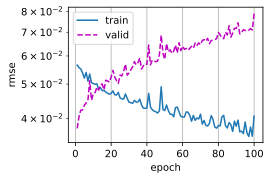

In [30]:
dropout_net = nn.Sequential(nn.Linear(in_features, 50),
                          nn.ReLU(),
                           nn.Dropout(0.5),
                           nn.Linear(50, 10),
                           nn.Dropout(0.2),
                           nn.ReLU(),
                           nn.Linear(10, 1))

dropout_net.apply(init_weights)

k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.05, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, 
                         weight_decay, batch_size, net=deeper_net)

print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
     f'avg valid log rmse: {float(valid_l):f}')

Maybe we should add some weight decay too?

fold 1, train log rmse 0.013094, valid log rmse 0.110485
fold 2, train log rmse 0.010270, valid log rmse 0.098369
fold 3, train log rmse 0.006348, valid log rmse 0.045793
fold 4, train log rmse 0.006085, valid log rmse 0.045506
fold 5, train log rmse 0.006690, valid log rmse 0.079845
5-fold validation: avg train log rmse: 0.008498, avg valid log rmse: 0.076000


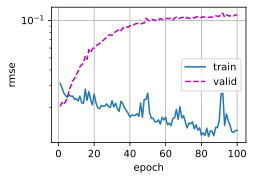

In [31]:
dropout_net = nn.Sequential(nn.Linear(in_features, 50),
                          nn.ReLU(),
                           nn.Dropout(0.5),
                           nn.Linear(50, 10),
                           nn.Dropout(0.2),
                           nn.ReLU(),
                           nn.Linear(10, 1))

dropout_net.apply(init_weights)

k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.05, 0.05, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, 
                         weight_decay, batch_size, net=deeper_net)

print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
     f'avg valid log rmse: {float(valid_l):f}')

Let's try a submission

train log rmse 0.334263


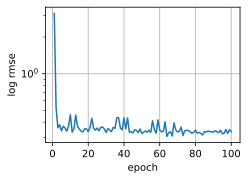

In [33]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, 
              lr, weight_decay, batch_size, fname="deeper_dropout_submission.csv", net=dropout_net)

OK, that didn't work..

How about a less deep model, still with some dropout? 

Let's also tune some hyperparameters

fold 1, train log rmse 0.247713, valid log rmse 0.238516
fold 2, train log rmse 0.223627, valid log rmse 0.224484
fold 3, train log rmse 0.226173, valid log rmse 0.219960
fold 4, train log rmse 0.218710, valid log rmse 0.216700
fold 5, train log rmse 0.217661, valid log rmse 0.240308
For the parameters:
Dropout: 0.500000, Layer width: 60, Weight decay: 0.000000, Learning rate: 0.010000
5-fold validation: avg train log rmse: 0.226777, avg valid log rmse: 0.227994
*************************
fold 1, train log rmse 0.211418, valid log rmse 0.212569
fold 2, train log rmse 0.203986, valid log rmse 0.214474
fold 3, train log rmse 0.203138, valid log rmse 0.212688
fold 4, train log rmse 0.214841, valid log rmse 0.245276
fold 5, train log rmse 0.205549, valid log rmse 0.208033
For the parameters:
Dropout: 0.500000, Layer width: 60, Weight decay: 0.000000, Learning rate: 0.050000
5-fold validation: avg train log rmse: 0.207786, avg valid log rmse: 0.218608
*************************
fold 1, train 

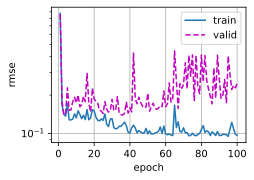

In [34]:
for dropout_prob in (0.5, 0.25, 0):
    for hidden_layer_width in (60, 30, 10):
        for weight_decay in (0, 0.01, 0.05):
            for lr in (0.01, 0.05, 0.1, 5):
                net = nn.Sequential(nn.Linear(in_features, hidden_layer_width),
                          nn.ReLU(),
                           nn.Dropout(dropout_prob),
                           nn.Linear(hidden_layer_width, 1))
                k, num_epochs, batch_size = 5, 100, 64
                train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, 
                                         weight_decay, batch_size, net=net)
                print("For the parameters:")
                print(f"Dropout: {dropout_prob:f}, Layer width: {hidden_layer_width}, "
                     f"Weight decay: {weight_decay:f}, Learning rate: {lr:f}")
                print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
                     f'avg valid log rmse: {float(valid_l):f}')
                print("*" * 25)
                





Let's try:

Dropout: 0.000000, Layer width: 30, Weight decay: 0.010000, Learning rate: 0.100000


train log rmse 0.121895


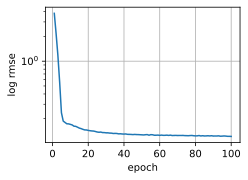

In [36]:
tuned_net = nn.Sequential(nn.Linear(in_features, 30),
                          nn.ReLU(),
                           nn.Dropout(0),
                           nn.Linear(30, 1))

train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, 
              lr=0.1, weight_decay=0.01, batch_size=batch_size, fname="after_tuning_submission.csv", net=tuned_net)